# Response to reviewers
### How does the retina finds the focal point with the LSC ?

In [1]:
rootF = 'D:/Data/Paper defocus/'

In [2]:
import os as os
import sys
import numpy as np
import pandas as pd
from scipy.stats import linregress, norm, fit
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.gridspec import SubplotSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from shared.save_load import load_obj, save_obj

In [3]:
experiments = [20211129, 20211207, 20211208, 20221213, 20221214, 20230105]

# Experiment conditions
from shared.parameters_stimulation2 import *
pixel_size_um = 3.5
pixel_per_check = 12
nb_checks = 60

mouse_dF_to_um_ratio = -5 #um
mouse_offset = np.linspace(40,-40,9) * mouse_dF_to_um_ratio
images = ['1','2','3','5']

# Load data

In [4]:
path_to_original_images = rootF + '/Eye model simulations/original images/'

### LSC and mean intensity

#### 4 images experiments

In [5]:
local_spatial_contrast_all_exps = []
mean_intensity_all_exps = []

for iExp in range(len(experiments)):
    exp = experiments[iExp]

    local_contrasts = load_obj(rootF + 'contrast analysis/local_contrast_2sigma_liu2022_exp' + str(exp) + '.pkl')
    mean_intensities = load_obj(rootF + '/contrast analysis/mean_intensities_2sigma_liu2022_exp' + str(exp) + '.pkl')
    print (exp, local_contrasts.shape)
    
    local_spatial_contrast_all_exps.append(local_contrasts)
    mean_intensity_all_exps.append(mean_intensities)

20211129 (68, 4, 2, 4, 9)
20211207 (112, 4, 2, 4, 9)
20211208 (113, 4, 2, 4, 9)
20221213 (56, 4, 2, 4, 9)
20221214 (81, 4, 2, 4, 9)
20230105 (143, 4, 2, 4, 9)


### Selected cells

In [6]:
cells_clustering_all_experiments = []

for iExp in range(len(experiments)):
    exp = experiments[iExp]

    cells_clustering = load_obj(rootF + '/MEA/exp' + str(exp) + '/' + str(exp) + '_selected_cells_clustering')
    cells_clustering = np.array(cells_clustering)
    cells_clustering_all_experiments.append(cells_clustering)
    print (exp, len(cells_clustering))

20211129 68
20211207 112
20211208 113
20221213 56
20221214 81
20230105 143


In [7]:
# Skipped cells because of bad ellipse fitting

skip_cells = np.array([[45, 80, 188, 192, 401, 408, 422, 525, 533, 558, 561, 614, 682], 
                       [33, 52, 145, 302, 340, 406, 414, 515],
                       [99,100,276,407,424,452,472,498],
                       [55, 180, 232, 294, 339, 365, 563, 570, 665, 680],
                       [40, 190, 332, 957],
                       [15, 96, 177, 221, 274, 320, 326, 389, 498, 558, 571, 689, 700, 791, 832, 856, 923, 928, 1018]], 
                      dtype='object')  

# Distribution of LSC as a function of defocus

In [8]:
iPup_exp = 0

# Mean LSC for each defocus and eccentricity

LSCs = np.zeros((2, len(mouse_offset), 511*4))
mean_LSC = np.zeros((2, len(mouse_offset)))
std_LSC = np.zeros((2, len(mouse_offset)))

for src in [0,2]:    
    for iDf in range(len(mouse_offset)):
        contrast = []
        for iExp in range(len(experiments)):
            for index in range(len(cells_clustering_all_experiments[iExp])):
                cell_nb = cells_clustering_all_experiments[iExp][index]
                if cell_nb not in skip_cells[iExp]:
                    for iImg in range(Nimgs):
                        contrast.append(local_spatial_contrast_all_exps[iExp][index,iImg,iPup_exp,src,iDf])
        LSCs[int(src/2), iDf] = contrast
        mean_LSC[int(src/2), iDf] = np.mean(contrast)
        std_LSC[int(src/2), iDf] = np.std(contrast)

In [9]:
# Interpolate mean LSC

defocus = np.linspace(-200, 200, num=401)

mean_LSC_interp = np.zeros((2, len(defocus)))
std_LSC_interp = np.zeros((2, len(defocus)))

for i in [0,1]:
    spl = CubicSpline(mouse_offset, mean_LSC[i])
    mean_LSC_interp[i] = spl(defocus)
    spl = CubicSpline(mouse_offset, std_LSC[i])
    std_LSC_interp[i] = spl(defocus)

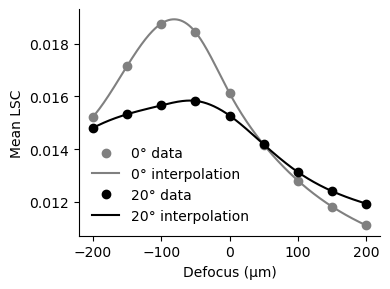

In [10]:
# Mean LSC vs defocus

fig = plt.figure(figsize=(4,3))
GS = fig.add_gridspec(1, 1)

ax = fig.add_subplot(GS[0])
ax.plot(mouse_offset, mean_LSC[0], 'o', color='grey',  label = ('0° data'))
ax.plot(defocus, mean_LSC_interp[0], '-', color='grey',  label = ('0° interpolation'))
ax.plot(mouse_offset, mean_LSC[1], 'o', color='k', label = ('20° data'))
ax.plot(defocus, mean_LSC_interp[1], 'k-', label = ('20° interpolation'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Mean LSC')
ax.set_xlabel('Defocus (µm)')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

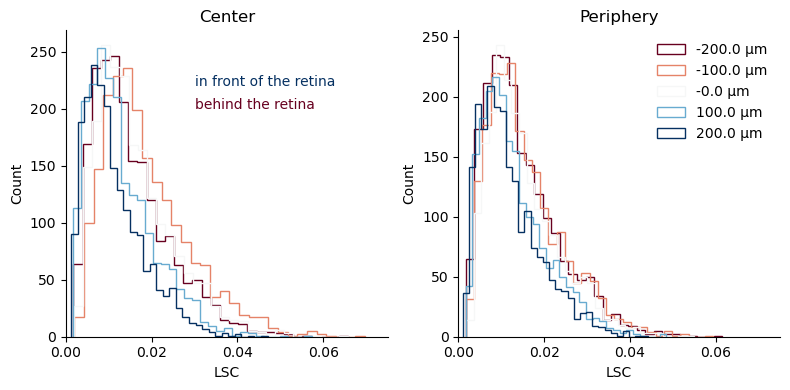

In [11]:
# Distribution of LSC

retina_ecc = ['Center', 'Periphery']

cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(dFs))]

fig = plt.figure(figsize=(8,4))
GS = fig.add_gridspec(1, 2)

for src in [0,2]:   
    N = 0 
    ax = fig.add_subplot(GS[int(src/2)])
    for iDf in [0,2,4,6,8]: #range(len(mouse_offset)):
        ax.hist(LSCs[int(src/2), iDf], bins=30, histtype='step', stacked=True, color=colors[iDf], label=str(mouse_offset[iDf]) + ' µm')
    ax.set_xlabel('LSC')
    ax.set_ylabel('Count')
    ax.set_xlim(0,0.075)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(retina_ecc[int(src/2)])
    if src == 2:
        ax.legend(frameon=False)
    else:
        ax.text(0.03, 220, 'in front of the retina', color = colors[-1])
        ax.text(0.03, 200, 'behind the retina', color = colors[0])

plt.tight_layout()
plt.show()

# Error in using the LSC to estimate the defocus

In [12]:
iEcc = 0

def gaussian_fit(x, mu, sigma):
    p = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )
    return p

N =  100 : C0 =  0.012773531569737642
N =  250 : C0 =  0.014378114047282975
N =  500 : C0 =  0.015909796449182997
N =  750 : C0 =  0.016814204047082858
N =  1000 : C0 =  0.016389052507293663
N =  1250 : C0 =  0.016430376234163237
N =  1500 : C0 =  0.016223453567322927
N =  1750 : C0 =  0.0161110755424762
N =  2000 : C0 =  0.016168655751873772
N =  2044 : C0 =  0.016121526140368648


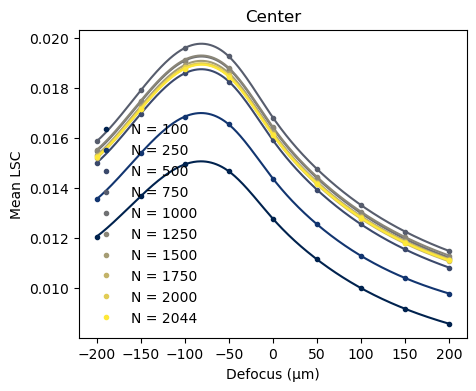

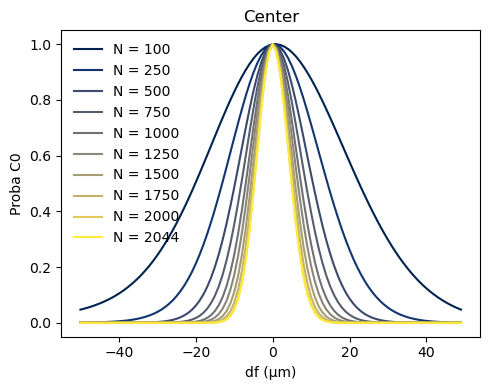

N =  100 : C0 =  0.011906904440495063
N =  250 : C0 =  0.013485553887665069
N =  500 : C0 =  0.014956536457309044
N =  750 : C0 =  0.01586650869514857
N =  1000 : C0 =  0.015471368591571145
N =  1250 : C0 =  0.01552819707330113
N =  1500 : C0 =  0.01534788244667817
N =  1750 : C0 =  0.015255937849730363
N =  2000 : C0 =  0.015318918483356047
N =  2044 : C0 =  0.015274541862066227


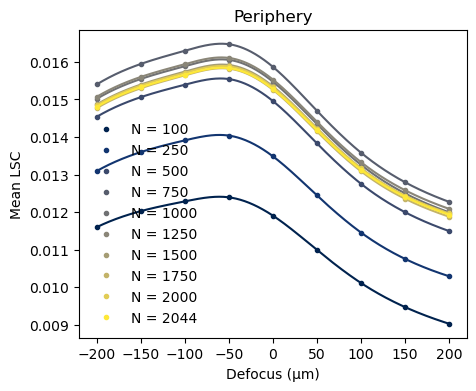

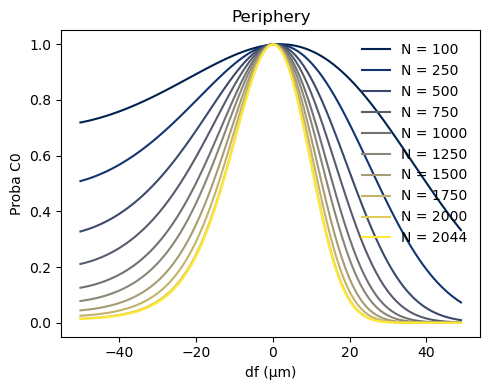

In [13]:
N_range = [100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2044]

cmap = plt.get_cmap('cividis')
colors = [cmap(i) for i in np.linspace(0, 1, len(N_range))]

defocus = np.linspace(-200, 200, num=401)
iDf_range = range(150, 250)

std_df = np.zeros((2, len(N_range)))
proba_c0s = np.zeros((2, len(N_range), len(iDf_range)))

mean_LSC_interp_N = np.zeros((2, len(N_range), len(defocus)))

for iEcc in [0, 2]:
    fig1 = plt.figure(figsize=(5,4))
    GS = fig1.add_gridspec(1, 1)
    ax = fig1.add_subplot(GS[0])
    ax.set_title(retina_ecc[int(iEcc/2)])
    # ax.plot(mouse_offset, mean_LSC[1], 'o', color='k', label = ('20° data'))

    fig2 = plt.figure(figsize=(5,4))
    GS2 = fig2.add_gridspec(1, 1)
    ax2 = fig2.add_subplot(GS2[0])
    ax2.set_title(retina_ecc[int(iEcc/2)])

    for n in range(len(N_range)):
        N = N_range[n]

        # Mean LSC over N samples

        LSC_N = np.zeros((len(mouse_offset), N))
        mean_LSC_N = np.zeros((len(mouse_offset)))
        std_LSC_N = np.zeros((len(mouse_offset)))

        for iDf in range(len(mouse_offset)):
            LSC_N[iDf] = LSCs[int(iEcc/2), iDf, :N]  #np.random.choice(LSCs[int(iEcc/2), iDf], size = N) #
            mean_LSC_N[iDf] = np.mean(LSC_N[iDf])
            std_LSC_N[iDf] = np.std(LSC_N[iDf])

        ax.plot(mouse_offset, mean_LSC_N, '.', color=colors[n], label = 'N = {}'.format(N))

        # Mean LSC on the retina (defocus = 0 µm) and interpolation

        c0 = mean_LSC_N[4]
        print ('N = ', N, ': C0 = ', c0)

        spl = CubicSpline(mouse_offset, mean_LSC_N)
        mean_LSC_N_interp = spl(defocus)
        mean_LSC_interp_N[int(iEcc/2), n, :] = mean_LSC_N_interp
        spl = CubicSpline(mouse_offset, std_LSC_N)
        std_LSC_N_interp = spl(defocus)

        ax.plot(defocus, mean_LSC_N_interp, '-', color=colors[n])

        # Distribution of the mean LSC vs defocus
        
        proba_c0 = []

        for iDf in iDf_range: 
            # Central limit theorem to obtain the mean and std of the distribution of the mean LSC
            mu = mean_LSC_N_interp[iDf]
            sigma = std_LSC_N_interp[iDf] / np.sqrt(N)

            s = np.random.normal(mu, sigma, 5000)
            count, bins = np.histogram(s, 30)
            proba_c0.append(gaussian_fit(c0, mu, sigma)) #/max(gaussian_fit(bins, mu, sigma)))
            
        proba_c0s[int(iEcc/2), n] = proba_c0

        ax2.plot(defocus[iDf_range], proba_c0/max(proba_c0), color=colors[n], label = 'N = {}'.format(N))

        # Generate data from this distribution

        data_df = []

        for i in range(len(proba_c0)):
            # number of occurence of df value
            n_df = proba_c0[i]
            for m in range(int(n_df)):
                data_df.append(defocus[iDf_range[i]])
        data_df = np.array(data_df)
        data_df_randomized = np.random.permutation(data_df)

        std_df[int(iEcc/2), n] = np.std(data_df_randomized)

    ax2.set_xlabel('df (µm)')
    ax2.set_ylabel('Proba C0')
    ax2.legend(frameon=False)

    ax.set_ylabel('Mean LSC')
    ax.set_xlabel('Defocus (µm)')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()



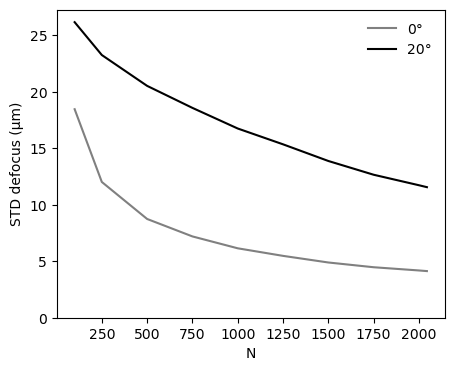

4.128155809133766 11.558943581040806


In [14]:
plt.figure(figsize=(5,4))
plt.plot(N_range, std_df[0], '-', color='grey', label='0°')
plt.plot(N_range, std_df[1], '-', color='k', label='20°')
plt.legend(frameon=False)
plt.xlabel('N')
plt.ylabel('STD defocus (µm)')
plt.ylim(0, None)
plt.show()

print (std_df[0, -1], std_df[1, -1])

# Figure

4.128155809133766 11.558943581040806


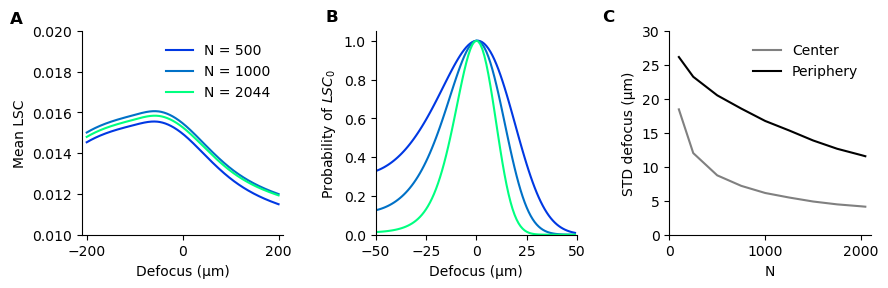

In [15]:
retina_ecc = ['Center', 'Periphery']

cmap = plt.get_cmap('winter')
colors = [cmap(i) for i in np.linspace(0, 1, len(N_range))]

cols = [colors[-3], 'blueviolet', 'fuchsia']

fig = plt.figure(figsize=(9,3))
GS = fig.add_gridspec(1, 3)

# Mean LSC vs defocus

ax = fig.add_subplot(GS[0, 0])
for n in [2, 4, 9]:
    ax.plot(defocus, mean_LSC_interp_N[1, n], '-', color = colors[n], label = 'N = {}'.format(N_range[n]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Mean LSC')
ax.set_xlabel('Defocus (µm)')
ax.set_xlim(-210, 210)
ax.set_ylim(0.01, 0.02)
ax.legend(frameon=False)
ax.text(-360, 0.0204, 'A', color='k', fontsize = 12, weight='bold')

# Proba C0

iEcc = 2
ax = fig.add_subplot(GS[0, 1])
for n in [2,4,9]:
    N = N_range[n]
    ax.plot(defocus[iDf_range], proba_c0s[int(iEcc/2), n]/max(proba_c0s[int(iEcc/2), n]), color=colors[n], label = 'N = {}'.format(N))
ax.set_xlabel('Defocus (µm)')
ax.set_ylabel('Probability of $LSC_0$')
ax.text(-75, 1.1, 'B', color='k', fontsize = 12, weight='bold')
ax.set_xlim(-50, 50)
ax.set_ylim(0, 1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# STD df vs N

ax = fig.add_subplot(GS[0, 2])
ax.plot(N_range, std_df[0], 'grey', label='Center')
ax.plot(N_range, std_df[1], 'k', label='Periphery')
ax.legend(frameon=False)
ax.set_xlabel('N')
ax.set_ylabel('STD defocus (µm)')
ax.set_ylim(0, 30)
ax.set_xlim(0,2100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-700, 31.4, 'C', color='k', fontsize = 12, weight='bold')

print (std_df[0, -1], std_df[1, -1])

plt.tight_layout()
plt.show()

### Save figure
fsave = 'T:/Documents/Papier defocus/figures/papier/'

# fig.savefig(fsave+'Supp_fig_search_best_focus.png', format='png', dpi=300)